# Is It A Bird?

## Checking Internet in the Notebook

In [5]:
import socket
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error:
    raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [6]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai icrawler

## Installing DuckDuckGo Search

In [7]:
!pip install -Uqq duckduckgo_search

## Setting Up Web Crawler

In [8]:
from icrawler import ImageDownloader
from icrawler.builtin import GoogleImageCrawler
from icrawler.builtin.google import GoogleFeeder, GoogleParser

class MyDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(MyDownloader, self).get_filename(task, default_ext)
        filename = filename.split(".")[0]
        return self.prefix + filename + ".png"

class MyCrawler(GoogleImageCrawler):
    def __init__(self, feeder_cls=GoogleFeeder, parser_cls=GoogleParser, downloader_cls=MyDownloader, prefix="", *args, **kwargs):
        super().__init__(feeder_cls, parser_cls, downloader_cls, *args, **kwargs)
        self.downloader.prefix = prefix

## Steps We Taking for First Image Recognition

1. Use DuckDuckGo to search for images of "bird photos"
2. Use DuckDuckGo to search for images of "forest photos"
3. Fine-tune a pretrained neural network to recognise these two groups
4. Try running this model on a picture of a bird and see if it works.

In [9]:
"""
Here we are defining search images function with following parameters
1. term: A string representing the search term used to find images.
2. max_images: An integer (default value of 30) specifying the 
   maximum number of images to search for.
3. folder_name: A string (default value ".") representing the folder where 
   the images will be saved.
"""
def search_images(term, max_images=30, folder_name="."):
    #using f-string to embed the value of term into the message.
    print(f"Searching for '{term}'")
    #executing web crawler function
    crawler = MyCrawler(
        prefix=term,
        storage={'root_dir': folder_name}, 
    )
    crawler.crawl(keyword=term, max_num=max_images)

In [10]:
#Searching for bird image picture
search_images("bird", 1)

Searching for 'bird'


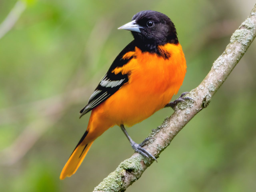

In [11]:
from fastai.vision.all import *
im = Image.open("bird000001.png")
im.to_thumb(256,256)#transforming in thumbnail

In [12]:
search_images("forest", 1)#searching for forest picture

Searching for 'forest'


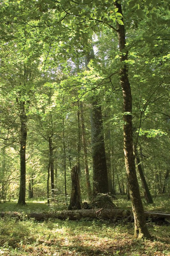

In [13]:
im = Image.open("forest000001.png")
im.to_thumb(256,256)

In [14]:
no_of_photos = 20 # Making default number of images as 20 for each query

#Defining the tuple with term search terms 'forest' and 'bird'
#Making sure he code will search for these keywords
searches = 'forest','bird'
#a path object is created using the folder name 'bird_or_not'
path = Path('bird_or_not')
from time import sleep

"""
For each keyword (o) in searches, we creating
a folder dest inside the path directory (e.g., bird_or_not/forest and bird_or_not/bird).
"""
for o in searches:
    dest = (path/o)
    # Ensuring the folder is created if it doesn’t already exists.
    # Including any missing parent directories.
    dest.mkdir(exist_ok=True, parents=True)
    # searching for images of "{o} photo", where o is either 'forest' or 'bird'
    # Downloding no_of_photos i.e. 20 in destination folder
    search_images(f"{o} photo", no_of_photos, dest)
    sleep(10)  # Pause between searches to avoid over-loading server
    search_images(f"{o} sun photo", no_of_photos, dest)
    sleep(10)
    search_images(f"{o} night photo", no_of_photos, dest) 
    # Changed this to get "night photo" instead of "shade photo" since the original would cause paint tones to be downloaded 
    sleep(10)
    print(f"Photos of {o} completed!")

# After all searches are complete, the images in the entire path directory (bird_or_not)are resized
resize_images(path, max_size=400, dest=path, recurse=True)
print(f"Photos resized!")

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest night photo'
Photos of forest completed!
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird night photo'
Photos of bird completed!


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Photos resized!


In [15]:
# get_image_files(path) unction retrieves a list of image files from the directory specified by path
# verify_images verifies the integrity of the images retrieved by get_image_files
# it checks for corrupted or unreadable files.
failed = verify_images(get_image_files(path))
# map() function applies the method Path.unlink to each item in the failed collection.
failed.map(Path.unlink)
#Returning number of failed image
len(failed)

0

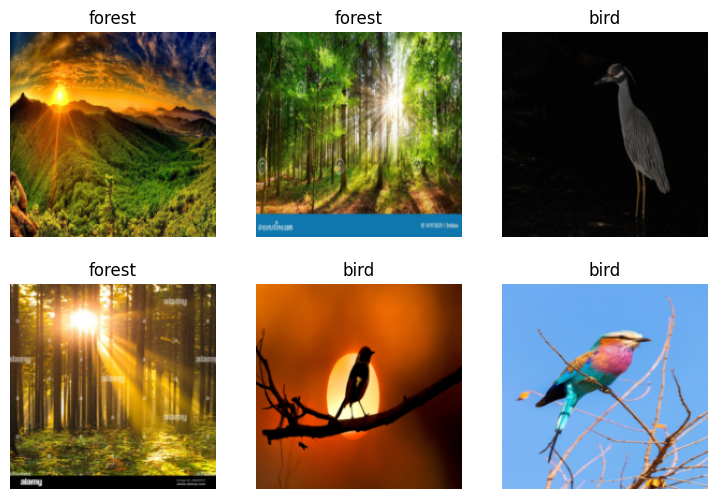

In [16]:
"""
DataBlock is a high-level API in fastai that is used to define how to get, split, label, and transform data.

1. blocks=(ImageBlock, CategoryBlock):
    ImageBlock: Indicates that the input is an image.
    CategoryBlock: Indicates that the labels (targets) are categorical (i.e., each image belongs to one of several classes).

2. get_image_files function retrieves all image files from the directory specified by path.
   These will be the dataset inputs.

3. splitter=RandomSplitter(valid_pct=0.2, seed=42):
    RandomSplitter: This function splits the dataset into training and validation sets.
    valid_pct=0.2: 20% of the dataset will be used for validation, and 80% will be used for training.
    seed=42: A random seed is provided to ensure that the data split is reproducible
    (i.e., the same split will occur each time the code is run).

4. get_y=parent_label:
    parent_label: This function extracts the label for each image based on its parent directory name.
    This means the images are organized in subdirectories where each directory corresponds to a specific class,
    and parent_label returns the class label from the directory name.

5. item_tfms=[Resize(192, method='squish')]:
    Resize(192, method='squish'): This applies a transformation to resize all images to 192 pixels while squishing
    them to fit the target size.
    The squish method will stretch or compress the images as needed to make them fit the specified size exactly.

"""
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)#  The DataLoaders object handles loading the data in batches for training and validation.
# Above The path parameter specifies the directory where the images are located, and bs=32 sets the batch size to 32.

# This method displays a batch of images along with their labels
# max_n=6 specifies that up to 6 images should be displayed from a single batch.
dls.show_batch(max_n=6)

In [17]:
# Training model with resnet18
learn = vision_learner(dls, resnet18, metrics=error_rate)
# fine_tune() method of fastai uses best practices for fine tuning a pre-trained model
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.205729,1.666807,0.375000,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.343789,0.592348,0.125000,00:11
1,0.255350,0.367293,0.083333,00:11
2,0.195652,0.320205,0.083333,00:11


In [18]:
is_bird,_,probs = learn.predict(PILImage.create('bird000001.png'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9977
